В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from process_bank_churn import preprocess_data, preprocess_new_data
import time

# Завантаження даних
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Препроцесінг
X_train, y_train, X_val, y_val, input_cols, scaler, encoder = preprocess_data(train_df, scale_numeric=True)

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [3]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Передбачення
train_preds = knn.predict_proba(X_train)[:,1]
val_preds = knn.predict_proba(X_val)[:,1]

# Оцінка якості
train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")


Train AUROC: 0.9617
Validation AUROC: 0.8679


**На тренуванні результат дуже високий, проте на валідації помітно нижчий. Модель не має проблеми high bias, вона добре вчить train. Різниця між train і val свідчить про overfitting/high variance. Для kNN це очікувано, бо метод чутливий до локальних особливостей даних і масштабу ознак.**

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [4]:
param_grid = {"n_neighbors": list(range(2, 31, 3))}
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
knn_best = grid_knn.best_estimator_

print("Найкращий параметр n_neighbors:", grid_knn.best_params_)

# Оцінка
train_preds_best = knn_best.predict_proba(X_train)[:,1]
val_preds_best = knn_best.predict_proba(X_val)[:,1]

print("Train AUROC:", roc_auc_score(y_train, train_preds_best))
print("Validation AUROC:", roc_auc_score(y_val, val_preds_best))


Найкращий параметр n_neighbors: {'n_neighbors': 29}
Train AUROC: 0.9343208861545823
Validation AUROC: 0.9101219089434536


**Розрив між train і validation тепер значно менший, що свідчить про зниження high variance. Модель стала більш збалансованою. Дерево рішень із попереднього ДЗ узагальнює дещо краще (0.9153 на validation).**

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [5]:
param_grid_dt = {
    "max_depth": list(range(1, 21, 2)),
    "max_leaf_nodes": list(range(2, 11, 1))
}

dt = DecisionTreeClassifier(random_state=42)

start = time.time()
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)
end = time.time()

dt_best = grid_dt.best_estimator_

print("Час пошуку:", end - start, "секунд")
print("Найкращі параметри:", grid_dt.best_params_)

# Оцінка
train_preds_dt = dt_best.predict_proba(X_train)[:,1]
val_preds_dt = dt_best.predict_proba(X_val)[:,1]

print("Train AUROC:", roc_auc_score(y_train, train_preds_dt))
print("Validation AUROC:", roc_auc_score(y_val, val_preds_dt))


Час пошуку: 1.032602071762085 секунд
Найкращі параметри: {'max_depth': 5, 'max_leaf_nodes': 10}
Train AUROC: 0.9073235544075688
Validation AUROC: 0.8880524407604071


**GridSearchCV за заданою сіткою підібрав більш просте дерево, яке показує нижчу якість на валідації. Модель стала менш складною і стабільнішою, але втратила прогностичну силу. Вона гірша за ту, що була знайдена вручну.**

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [6]:
params_dt = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": np.arange(1, 20),
    "max_leaf_nodes": np.arange(2, 20),
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"]
}

dt = DecisionTreeClassifier(random_state=42)

start = time.time()
random_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=params_dt,
    n_iter=40,
    cv=3,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)
random_dt.fit(X_train, y_train)
end = time.time()

dt_random_search_best = random_dt.best_estimator_

print("Час пошуку:", end - start, "секунд")
print("Найкращі параметри:", random_dt.best_params_)

# Оцінка
train_preds_dt_rand = dt_random_search_best.predict_proba(X_train)[:,1]
val_preds_dt_rand = dt_random_search_best.predict_proba(X_val)[:,1]

print("Train AUROC:", roc_auc_score(y_train, train_preds_dt_rand))
print("Validation AUROC:", roc_auc_score(y_val, val_preds_dt_rand))


Час пошуку: 0.4089169502258301 секунд
Найкращі параметри: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Train AUROC: 0.9183779916036456
Validation AUROC: 0.9025238054687034


**RandomizedSearchCV підібрав більш складну та збалансовану модель, яка перевершує GridSearchCV. Головною відмінністю у параметрах є те, що RandomizedSearch дозволив знайти комбінацію глибини та обмежень, яка дала кращий баланс між bias і variance.**

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [7]:
X_test = preprocess_new_data(test_df, input_cols, encoder, scaler)

# Передбачення найкращою моделлю kNN
test_preds = knn_best.predict_proba(X_test)[:,1]

submission = sample_submission.copy()
submission["Exited"] = test_preds
submission.to_csv("submission_knn_best.csv", index=False)

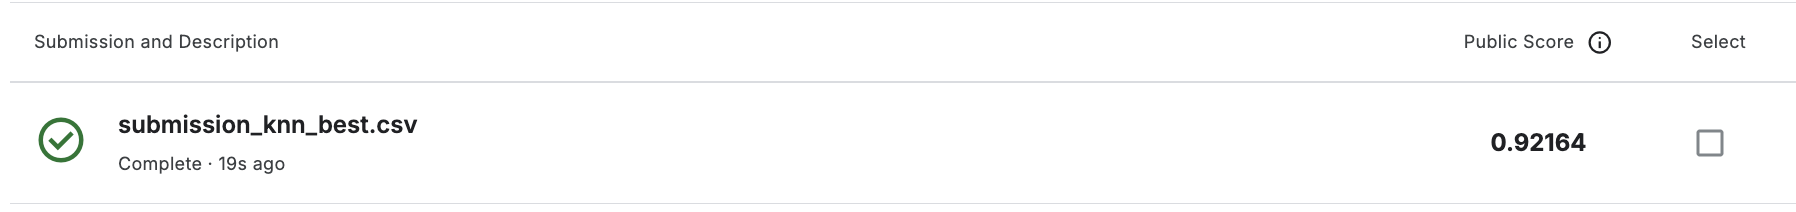